# Abstraction Alignment to Interpret a CIFAR-100 Model
We apply abstraction alignment to interpret a CIFAR-100 image classification model. We use the CIFAR-100 class-superclass hierarchy as the human abstraction. In this notebook, we:
1. train and evaluate a ResNet20 on CIFAR-100
2. aggregate and report the model's level-wise entropy and level-wise accuracy
3. qualitatively analyze common "types" of abstraction (mis)alignment

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from itertools import combinations

import cifar
import cifar_util
import cifar_train
import cifar_metadata

sns.set_style("whitegrid")

### CIFAR-100 Model and Dataset
First, we load the CIFAR-100 dataset and train a ResNet20 on it. This is the model we will inspect with abstraction alignment.

In [4]:
# User-defined paths -- TODO: update with your own
MODEL_PATH = 'models/'
CIFAR_DIR = '/nobackup/users/aboggust/data/cifar'

In [5]:
# Train a ResNet20 on CIFAR-100
batch_size = 128
data_augmentation = True
epochs = 200
architecture = 'resnet20'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = os.path.join(MODEL_PATH, architecture, 'checkpoints', 'checkpoint.pt')
if os.path.isfile(checkpoint):
    print(f'Loading trained CIFAR-100 model from: {checkpoint}')
    model = cifar_util.load_model(architecture)
    model.load_state_dict(torch.load(checkpoint))
else:
    print(f'Training CIFAR-100 model')
    model = cifar_train.train(architecture, 
                              batch_size, 
                              epochs, 
                              CIFAR_DIR,
                              MODEL_PATH)
    
model.to(device)
model = model.eval()

Loading trained CIFAR-100 model from: models/resnet20/checkpoints/checkpoint.pt


In [6]:
# Load the CIFAR-100 dataset for exploration
train_loader, test_loader = cifar_util.load_dataset(CIFAR_DIR, 
                                                    data_augmentation,
                                                    batch_size)
test_dataset = test_loader.dataset

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Compute model outputs on test instances
labels = []
outputs = []

for i, (image, label) in enumerate(tqdm(test_loader)):
    with torch.no_grad():
        images = image.to(device)
    labels.extend(label.numpy())

    # Compute model inferences
    output = model(images)
    output = torch.nn.functional.softmax(output, dim=1).squeeze(0).detach().cpu().numpy()
    outputs.append(output)
    
outputs = np.vstack(outputs)

100%|███████████████████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.85it/s]


In [8]:
# Print model performance statistics
predictions = [np.argmax(output) for output in outputs]
correctness = [label == predictions[i] for i, label in enumerate(labels)]
correct_inds = [i for i, label in enumerate(labels) if label == predictions[i]]
incorrect_inds = [i for i, label in enumerate(labels) if label != predictions[i]]
print(f'MODEL STATS:')
print(f'Accuracy: {len(correct_inds) / len(labels):.2%}')
print(f'Mean prediction confidence: {np.mean([np.max(output) for output in outputs]):.2f}')
print(f'Mean prediction confidence (correct): {np.mean([np.max(outputs[i]) for i in correct_inds]):.2f}')
print(f'Mean prediction confidence (incorrect): {np.mean([np.max(outputs[i]) for i in correct_inds]):.2f}')

MODEL STATS:
Accuracy: 67.68%
Mean prediction confidence: 0.78
Mean prediction confidence (correct): 0.87
Mean prediction confidence (incorrect): 0.87


### Compute Abstraction Alignment

In [9]:
# Load the human hierarchy --- i.e., the CIFAR-100 class and superclass structure
tree = cifar.make_tree()
print(f'CIFAR-100 tree with {tree.size()} nodes across {tree.depth() + 1} levels.')
print(cifar.show(tree))

CIFAR-100 tree with 121 nodes across 3 levels.
root (None)
├── aquatic_mammals (None)
│   ├── beaver (None)
│   ├── dolphin (None)
│   ├── otter (None)
│   ├── seal (None)
│   └── whale (None)
├── fish (None)
│   ├── aquarium_fish (None)
│   ├── flatfish (None)
│   ├── ray (None)
│   ├── shark (None)
│   └── trout (None)
├── flowers (None)
│   ├── orchid (None)
│   ├── poppy (None)
│   ├── rose (None)
│   ├── sunflower (None)
│   └── tulip (None)
├── food_containers (None)
│   ├── bottle (None)
│   ├── bowl (None)
│   ├── can (None)
│   ├── cup (None)
│   └── plate (None)
├── fruit_and_vegetables (None)
│   ├── apple (None)
│   ├── mushroom (None)
│   ├── orange (None)
│   ├── pear (None)
│   └── sweet_pepper (None)
├── household_electrical_devices (None)
│   ├── clock (None)
│   ├── keyboard (None)
│   ├── lamp (None)
│   ├── telephone (None)
│   └── television (None)
├── household_furniture (None)
│   ├── bed (None)
│   ├── chair (None)
│   ├── couch (None)
│   ├── table (None)
│   └

In [10]:
# Measure abstraction alignment by propagating model outputs through the hierarchy
trees = []
for i in tqdm(range(len(labels))):
    tree = cifar.propagate(outputs[i], cifar.make_tree())
    trees.append(tree)

100%|█████████████████████████████████████████████████████████████████| 10000/10000 [01:48<00:00, 91.87it/s]


CIFAR-100 IMAGE


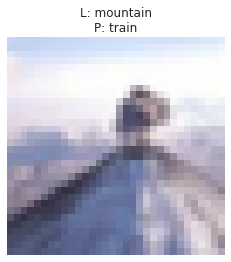

TOP PREDICTED CLASSES:  ['train (0.37)', 'road (0.18)', 'spider (0.17)']
PROPAGATED TREE:
root (1.00)
├── aquatic_mammals (0.03)
│   ├── beaver ()
│   ├── dolphin ()
│   ├── otter ()
│   ├── seal (0.02)
│   └── whale ()
├── fish ()
│   ├── aquarium_fish ()
│   ├── flatfish ()
│   ├── ray ()
│   ├── shark ()
│   └── trout ()
├── flowers ()
│   ├── orchid ()
│   ├── poppy ()
│   ├── rose ()
│   ├── sunflower ()
│   └── tulip ()
├── food_containers ()
│   ├── bottle ()
│   ├── bowl ()
│   ├── can ()
│   ├── cup ()
│   └── plate ()
├── fruit_and_vegetables ()
│   ├── apple ()
│   ├── mushroom ()
│   ├── orange ()
│   ├── pear ()
│   └── sweet_pepper ()
├── household_electrical_devices ()
│   ├── clock ()
│   ├── keyboard ()
│   ├── lamp ()
│   ├── telephone ()
│   └── television ()
├── household_furniture (0.01)
│   ├── bed ()
│   ├── chair ()
│   ├── couch (0.01)
│   ├── table ()
│   └── wardrobe ()
├── insects (0.03)
│   ├── bee ()
│   ├── beetle ()
│   ├── butterfly ()
│   ├── caterpill

In [11]:
# An example hierarchy propagation
index = 0

print('CIFAR-100 IMAGE')
image = test_dataset[index][0].permute(1, 2, 0)
plt.imshow(cifar_util.unnorm_cifar_image(image))
plt.axis('off')
plt.title(f'L: {cifar_metadata.CLASS_LABELS[labels[index]]}\nP: {cifar_metadata.CLASS_LABELS[predictions[index]]}')
plt.show()

top_predictions = np.argsort(outputs[index])[-3:]
print('TOP PREDICTED CLASSES: ', [f'{cifar_metadata.CLASS_LABELS[i]} ({outputs[index][i]:.2f})' for i in top_predictions][::-1])

print('PROPAGATED TREE:')
print(cifar.show(trees[0]))

### Analysis of model abstraction alignment

In [12]:
# Compute class and superclass accuracy and entropy

# Confidence vectors, correctness, and entropy for the class and superclass levels for every instance
class_confidences = []
class_correctness = []
class_entropy = []
superclass_confidences = []
superclass_correctness = []
superclass_entropy = []
for i, tree in enumerate(tqdm(trees)):
    class_confidence = [tree.get_node(c).data for c in cifar_metadata.CLASS_LABELS]
    class_confidences.append(class_confidence)
    assert np.argmax(class_confidence) == predictions[i]
    class_correctness.append(np.argmax(class_confidence) == labels[i])
    class_entropy.append(stats.entropy(class_confidence))
    
    superclass_confidence = [tree.get_node(s).data for s in cifar_metadata.SUPERCLASS_LABELS]
    superclass_confidences.append(superclass_confidence)
    superclass_correctness.append(np.argmax(superclass_confidence) == cifar_metadata.CLASS_TO_SUPERCLASS[labels[i]])
    superclass_entropy.append(stats.entropy(superclass_confidence))
class_confidences = np.array(class_confidences)
class_correctness = np.array(class_correctness)
class_entropy = np.array(class_entropy)
superclass_confidences = np.array(superclass_confidences)
superclass_correctness = np.array(superclass_correctness)
superclass_entropy = np.array(superclass_entropy)

print('CONFIDENCE, CORRECTNESS, AND ENTROPY FOR EVERY INSTANCE AT THE CLASS AND SUPERCLASS LEVEL')
print(f'Class confidence {class_confidences.shape}; all sum to one: {np.all([np.isclose(np.sum(c), 1.0) for c in class_confidences])}')
print(f'Class correctness {class_correctness.shape}; equal to accuracy: {np.sum(class_correctness)/len(class_correctness):.2%}')
print(f'Class entropy {class_entropy.shape}')
print(f'Superclass confidence {superclass_confidences.shape}; all sum to one: {np.all([np.isclose(np.sum(c), 1.0) for c in superclass_confidences])}')
print(f'Superclass correctness {superclass_correctness.shape}; superclass accuracy: {np.sum(superclass_correctness)/len(superclass_correctness):.2%}')
print(f'Superclass entropy {superclass_entropy.shape}')

print(f'ACCURACY -- class-level: {np.sum(class_correctness)/len(class_correctness):.2%}; superclass-level: {np.sum(superclass_correctness)/len(superclass_correctness):.2%}')
print(f'ENTROPY --- class-level: {np.mean(class_entropy):.2f}; superclass-level: {np.mean(superclass_entropy):.2f}')

100%|███████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2426.89it/s]


CONFIDENCE, CORRECTNESS, AND ENTROPY FOR EVERY INSTANCE AT THE CLASS AND SUPERCLASS LEVEL
Class confidence (10000, 100); all sum to one: True
Class correctness (10000,); equal to accuracy: 67.68%
Class entropy (10000,)
Superclass confidence (10000, 20); all sum to one: True
Superclass correctness (10000,); superclass accuracy: 78.94%
Superclass entropy (10000,)
ACCURACY -- class-level: 67.68%; superclass-level: 78.94%
ENTROPY --- class-level: 0.71; superclass-level: 0.43


In [13]:
# Compute statisitics per class and superclass label
grouped_correctness = {}
grouped_entropy = {}
for superclass_name in cifar_metadata.SUPERCLASS_LABELS:
    grouped_correctness[superclass_name] = []
    grouped_entropy[superclass_name] = []
    for class_name in cifar_metadata.SUPERCLASS_TO_CLASS[superclass_name]:
        grouped_correctness[class_name] = []
        grouped_entropy[class_name] = []

for i, label in enumerate(labels):
    label_name = cifar_metadata.CLASS_LABELS[label]
    superclass_label_name = cifar_metadata.CLASS_TO_SUPERCLASS[label_name]
    
    grouped_correctness[label_name].append(class_correctness[i])
    grouped_correctness[superclass_label_name].append(superclass_correctness[i])
    
    grouped_entropy[label_name].append(class_entropy[i])
    grouped_entropy[superclass_label_name].append(superclass_entropy[i])

grouped_accuracy = {k: np.mean(v) for k, v in grouped_correctness.items()}
grouped_mean_entropy = {k: np.mean(v) for k, v in grouped_entropy.items()}

print('Computed accuracy and entropy split by class and superclass label')
print('Accuracy', [f'{k}: {grouped_accuracy[k]:.2f}' for k in list(grouped_accuracy.keys())[:5]])
print('Entropy', [f'{k}: {grouped_mean_entropy[k]:.2f}' for k in list(grouped_mean_entropy.keys())[:5]])

Computed accuracy and entropy split by class and superclass label
Accuracy ['aquatic_mammals: 0.68', 'beaver: 0.51', 'dolphin: 0.68', 'otter: 0.38', 'seal: 0.39']
Entropy ['aquatic_mammals: 0.60', 'beaver: 1.04', 'dolphin: 0.73', 'otter: 1.31', 'seal: 1.08']


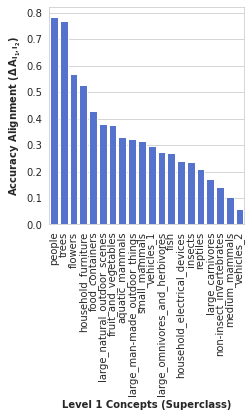

In [30]:
# Plot change in accuracy at the class vs. superclass level
change_in_acc = {}
for superclass in cifar_metadata.SUPERCLASS_LABELS:
    mean_class_acc = np.mean([grouped_accuracy[c] for c in cifar_metadata.SUPERCLASS_TO_CLASS[superclass]])
    change_in_acc[superclass] = (grouped_accuracy[superclass] - mean_class_acc) / (1 - mean_class_acc)

acc_order = sorted(cifar_metadata.SUPERCLASS_LABELS, key=lambda k: change_in_acc[k], reverse=True)

acc_df = pd.DataFrame.from_dict({
    'label': acc_order,
    'change in accuracy': [change_in_acc[x] for x in acc_order],
})

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(3.5, 4))
ax = sns.barplot(acc_df, 
                 x='label', 
                 y='change in accuracy', 
                 color='royalblue', 
                 dodge=False,
                 ax=axes)
plt.xlabel('Level 1 Concepts (Superclass)', fontweight='bold')
plt.ylabel('Accuracy Alignment ($\\bf{\Delta\, A_{l_1,l_2}}$)', fontweight='bold')
# plt.title('Accuracy Abstraction Alignment Grouped By Level 1 Class', fontweight='bold')
plt.xticks(rotation=90);

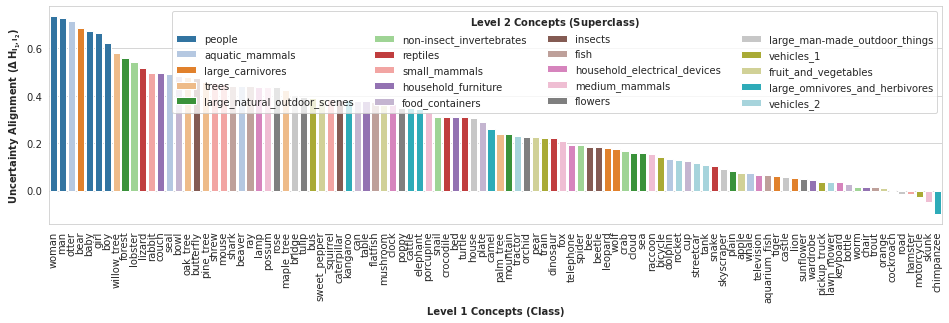

In [31]:
# Plot change in entropy per class
change_in_entropy = {}
for class_name in cifar_metadata.CLASS_LABELS:
    superclass_name = cifar_metadata.CLASS_TO_SUPERCLASS[class_name]
    change_in_entropy[class_name] = grouped_mean_entropy[class_name] - grouped_mean_entropy[superclass_name]

ent_order = sorted(cifar_metadata.CLASS_LABELS, key=lambda k: change_in_entropy[k], reverse=True)

ent_df = pd.DataFrame.from_dict({
    'class': ent_order,
    'superclass': [cifar_metadata.CLASS_TO_SUPERCLASS[c] for c in ent_order],
    'change_in_entropy': [change_in_entropy[x] for x in ent_order],
})
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
ax = sns.barplot(ent_df, x='class', y='change_in_entropy', 
                 hue='superclass', 
                 dodge=False,
                 palette='tab20',
                 ax=axes)
plt.legend(loc="upper right", ncol=4, title='$\\bf{Level}$ $\\bf{2}$ $\\bf{Concepts}$ $\\bf{(Superclass)}$')
plt.xlabel('Level 1 Concepts (Class)', fontweight='bold')
plt.ylabel('Uncertainty Alignment ($\\bf{\Delta\, H_{l_1,l_2}}$)', fontweight='bold')
# plt.title('Difference between class-level and superclass-level mean entropy grouped by label.', loc='left', fontweight='bold')
plt.xticks(rotation=90);

In [35]:
grouped_mean_entropy['chimpanzee']

0.41134328

In [37]:
grouped_mean_entropy['large_omnivores_and_herbivores']

0.5093704

In [38]:
grouped_mean_entropy['camel']

0.7690922

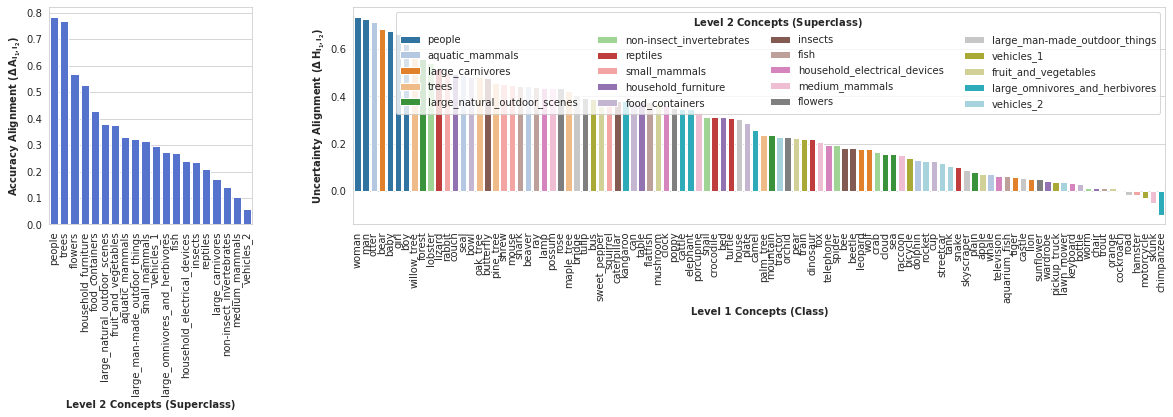

In [32]:
# Plot them side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4), gridspec_kw={'width_ratios': [1, 4]})
sns.barplot(acc_df, 
                 x='label', 
                 y='change in accuracy', 
                 color='royalblue', 
                 dodge=False,
                 ax=axes[0])
axes[0].set_xlabel('Level 2 Concepts (Superclass)', fontweight='bold')
axes[0].set_ylabel('Accuracy Alignment ($\\bf{\Delta\, A_{l_1,l_2}}$)', fontweight='bold')
axes[0].tick_params(axis='x', labelrotation=90);

sns.barplot(ent_df, x='class', y='change_in_entropy', 
                 hue='superclass', 
                 dodge=False,
                 palette='tab20',
                 ax=axes[1])
axes[1].legend(loc="upper right", ncol=4, title='$\\bf{Level}$ $\\bf{2}$ $\\bf{Concepts}$ $\\bf{(Superclass)}$')
axes[1].set_xlabel('Level 1 Concepts (Class)', fontweight='bold')
axes[1].set_ylabel('Uncertainty Alignment ($\\bf{\Delta\, H_{l_1,l_2}}$)', fontweight='bold')
axes[1].tick_params(axis='x', labelrotation=90);

In [33]:
fig.savefig(
    "cifar_acc_alignment.pdf",
    # we need a bounding box in inches
    bbox_inches=mtransforms.Bbox(
        # This is in "figure fraction" for the bottom half
        # input in [[xmin, ymin], [xmax, ymax]]
        [[0.09, -0.52], [0.27, 0.93]]
    ).transformed(
        # this take data from figure fraction -> inches
        #    transFigrue goes from figure fraction -> pixels
        #    dpi_scale_trans goes from inches -> pixels
        (fig.transFigure - fig.dpi_scale_trans)
    ),
)

In [34]:
fig.savefig(
    "cifar_conf_alignment.pdf",
    # we need a bounding box in inches
    bbox_inches=mtransforms.Bbox(
        # This is in "figure fraction" for the bottom half
        # input in [[xmin, ymin], [xmax, ymax]]
        [[0.3, -0.52], [0.91, 0.93]]
    ).transformed(
        # this take data from figure fraction -> inches
        #    transFigrue goes from figure fraction -> pixels
        #    dpi_scale_trans goes from inches -> pixels
        (fig.transFigure - fig.dpi_scale_trans)
    ),
)

#### Examples of different behavior types

In [23]:
def show_examples(indicies, num_examples):
    if len(indicies) > 0:
        example_inds = np.random.choice(indicies, num_examples)
        plot_images(example_inds)
        plt.show()
        print(cifar.show(trees[example_inds[0]]))

def plot_images(indicies):
    fig, ax = plt.subplots(nrows=1, ncols=len(indicies))
    if type(ax) != list:
        ax = [ax]
    for i, index in enumerate(indicies):
        ax[i].imshow(cifar_util.unnorm_cifar_image(test_dataset[index][0].permute(1, 2, 0)))
        ax[i].axis('off')
    return fig

2015 images where the model is fully confident in one output.


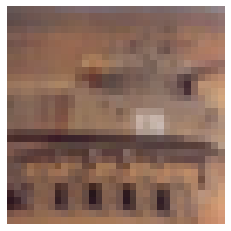

root (1.00)
├── aquatic_mammals ()
│   ├── beaver ()
│   ├── dolphin ()
│   ├── otter ()
│   ├── seal ()
│   └── whale ()
├── fish ()
│   ├── aquarium_fish ()
│   ├── flatfish ()
│   ├── ray ()
│   ├── shark ()
│   └── trout ()
├── flowers ()
│   ├── orchid ()
│   ├── poppy ()
│   ├── rose ()
│   ├── sunflower ()
│   └── tulip ()
├── food_containers ()
│   ├── bottle ()
│   ├── bowl ()
│   ├── can ()
│   ├── cup ()
│   └── plate ()
├── fruit_and_vegetables ()
│   ├── apple ()
│   ├── mushroom ()
│   ├── orange ()
│   ├── pear ()
│   └── sweet_pepper ()
├── household_electrical_devices ()
│   ├── clock ()
│   ├── keyboard ()
│   ├── lamp ()
│   ├── telephone ()
│   └── television ()
├── household_furniture ()
│   ├── bed ()
│   ├── chair ()
│   ├── couch ()
│   ├── table ()
│   └── wardrobe ()
├── insects ()
│   ├── bee ()
│   ├── beetle ()
│   ├── butterfly ()
│   ├── caterpillar ()
│   └── cockroach ()
├── large_carnivores ()
│   ├── bear ()
│   ├── leopard ()
│   ├── lion ()
│   ├── 

In [24]:
# Fully confident in an output class
fully_confident = [i for i, confidence in enumerate(class_confidences) if np.max(confidence) >= 0.995]
print(f'{len(fully_confident)} images where the model is fully confident in one output.')
show_examples(fully_confident, 1)

3475 images where the model is fully confident in a superclass.


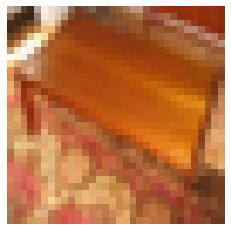

root (1.00)
├── aquatic_mammals ()
│   ├── beaver ()
│   ├── dolphin ()
│   ├── otter ()
│   ├── seal ()
│   └── whale ()
├── fish ()
│   ├── aquarium_fish ()
│   ├── flatfish ()
│   ├── ray ()
│   ├── shark ()
│   └── trout ()
├── flowers ()
│   ├── orchid ()
│   ├── poppy ()
│   ├── rose ()
│   ├── sunflower ()
│   └── tulip ()
├── food_containers ()
│   ├── bottle ()
│   ├── bowl ()
│   ├── can ()
│   ├── cup ()
│   └── plate ()
├── fruit_and_vegetables ()
│   ├── apple ()
│   ├── mushroom ()
│   ├── orange ()
│   ├── pear ()
│   └── sweet_pepper ()
├── household_electrical_devices ()
│   ├── clock ()
│   ├── keyboard ()
│   ├── lamp ()
│   ├── telephone ()
│   └── television ()
├── household_furniture (1.00)
│   ├── bed (0.02)
│   ├── chair ()
│   ├── couch ()
│   ├── table (0.98)
│   └── wardrobe ()
├── insects ()
│   ├── bee ()
│   ├── beetle ()
│   ├── butterfly ()
│   ├── caterpillar ()
│   └── cockroach ()
├── large_carnivores ()
│   ├── bear ()
│   ├── leopard ()
│   ├── lion

In [25]:
# Fully confident at the superclass level
superclass_confident = [i for i, confidence in enumerate(superclass_confidences) if np.max(confidence) >= 0.995]
print(f'{len(superclass_confident)} images where the model is fully confident in a superclass.')
show_examples(superclass_confident, 1)

20 images where the model is split across every class in a superclass.


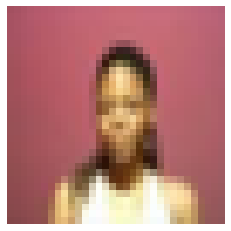

root (1.00)
├── aquatic_mammals ()
│   ├── beaver ()
│   ├── dolphin ()
│   ├── otter ()
│   ├── seal ()
│   └── whale ()
├── fish ()
│   ├── aquarium_fish ()
│   ├── flatfish ()
│   ├── ray ()
│   ├── shark ()
│   └── trout ()
├── flowers ()
│   ├── orchid ()
│   ├── poppy ()
│   ├── rose ()
│   ├── sunflower ()
│   └── tulip ()
├── food_containers ()
│   ├── bottle ()
│   ├── bowl ()
│   ├── can ()
│   ├── cup ()
│   └── plate ()
├── fruit_and_vegetables ()
│   ├── apple ()
│   ├── mushroom ()
│   ├── orange ()
│   ├── pear ()
│   └── sweet_pepper ()
├── household_electrical_devices ()
│   ├── clock ()
│   ├── keyboard ()
│   ├── lamp ()
│   ├── telephone ()
│   └── television ()
├── household_furniture ()
│   ├── bed ()
│   ├── chair ()
│   ├── couch ()
│   ├── table ()
│   └── wardrobe ()
├── insects ()
│   ├── bee ()
│   ├── beetle ()
│   ├── butterfly ()
│   ├── caterpillar ()
│   └── cockroach ()
├── large_carnivores ()
│   ├── bear ()
│   ├── leopard ()
│   ├── lion ()
│   ├── 

In [31]:
# Confidence within subtree
within_subtree = []
for i, confidence in enumerate(class_confidences):
    if np.max(superclass_confidences[i]) >= 0.995:
        num_non_zero = np.sum([c >= 0.01 for c in confidence])
        if num_non_zero == 5:
            within_subtree.append(i)
print(f'{len(within_subtree)} images where the model is split across every class in a superclass.')
show_examples(within_subtree, 1)

39 images where the model is split between two branches through two superclass.


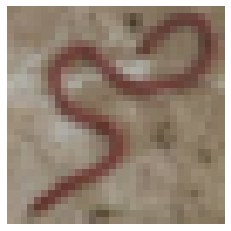

root (1.00)
├── aquatic_mammals ()
│   ├── beaver ()
│   ├── dolphin ()
│   ├── otter ()
│   ├── seal ()
│   └── whale ()
├── fish ()
│   ├── aquarium_fish ()
│   ├── flatfish ()
│   ├── ray ()
│   ├── shark ()
│   └── trout ()
├── flowers ()
│   ├── orchid ()
│   ├── poppy ()
│   ├── rose ()
│   ├── sunflower ()
│   └── tulip ()
├── food_containers ()
│   ├── bottle ()
│   ├── bowl ()
│   ├── can ()
│   ├── cup ()
│   └── plate ()
├── fruit_and_vegetables ()
│   ├── apple ()
│   ├── mushroom ()
│   ├── orange ()
│   ├── pear ()
│   └── sweet_pepper ()
├── household_electrical_devices ()
│   ├── clock ()
│   ├── keyboard ()
│   ├── lamp ()
│   ├── telephone ()
│   └── television ()
├── household_furniture ()
│   ├── bed ()
│   ├── chair ()
│   ├── couch ()
│   ├── table ()
│   └── wardrobe ()
├── insects ()
│   ├── bee ()
│   ├── beetle ()
│   ├── butterfly ()
│   ├── caterpillar ()
│   └── cockroach ()
├── large_carnivores ()
│   ├── bear ()
│   ├── leopard ()
│   ├── lion ()
│   ├── 

In [29]:
# Confidence in two independent branches
two_branches = []
for i, conf in enumerate(class_confidences):
    superclass_conf = superclass_confidences[i]
    num_non_zero_class = np.sum([c >= 0.01 for c in conf])
    num_non_zero_superclass = np.sum([c >= 0.01 for c in superclass_conf])
    if num_non_zero_class > 2 or num_non_zero_superclass > 2:
        continue
    if 0.4 <= np.max(conf) <= 0.6 and 0.4 <= np.max(superclass_conf) <= 0.6:
        two_branches.append(i)

print(f'{len(two_branches)} images where the model is split between two branches through two superclass.')
show_examples(two_branches, 1)

#### Examples of common confusions

In [22]:
all_nodes = tree.nodes
node_pairs = {}
for pair in combinations(tree.nodes.keys(), 2):
    if 'root' in pair:
        continue
    if tree.is_ancestor(pair[0], pair[1]) or tree.is_ancestor(pair[1], pair[0]):
        continue
    node_pairs[pair] = 0

for tree in tqdm(trees):
    for node_a_id, node_b_id in node_pairs:
        node_a = tree.get_node(node_a_id)
        node_b = tree.get_node(node_b_id)
        if node_a.data < 0.0001 or node_b.data < 0.0001:
            continue
        value = stats.entropy([node_a.data, node_b.data])
        node_pairs[(node_a.identifier, node_b.identifier)] += value

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [13:09<00:00, 12.67it/s]


In [33]:
normalized_node_pairs = {}
for pair in node_pairs:
    normalized_node_pairs[pair] = node_pairs[pair] / (stats.entropy([0.5,0.5])*len(trees))

In [34]:
# Highest overall confusion
sorted_pairs = [k for k, v in sorted(normalized_node_pairs.items(), key=lambda item: item[1], reverse=True)]
print('HIGHEST OVERALL CONFUSION:')
for i in range(5):
    print(f'{sorted_pairs[i]} --- {normalized_node_pairs[sorted_pairs[i]]:.2f}')

HIGHEST OVERALL CONFUSION:
('non-insect_invertebrates', 'reptiles') --- 0.20
('medium_mammals', 'small_mammals') --- 0.20
('large_carnivores', 'medium_mammals') --- 0.19
('large_carnivores', 'large_omnivores_and_herbivores') --- 0.19
('insects', 'non-insect_invertebrates') --- 0.19


In [35]:
# Confusion between superclass nodes
superclass_pairs = [(a, b) for a, b in sorted_pairs if tree.depth(a) == 1 and tree.depth(b) == 1]
print('HIGHEST SUPERCLASS CONFUSION:')
for i in range(5):
    print(f'{superclass_pairs[i]} --- {normalized_node_pairs[superclass_pairs[i]]:.2f}')

HIGHEST SUPERCLASS CONFUSION:
('non-insect_invertebrates', 'reptiles') --- 0.20
('medium_mammals', 'small_mammals') --- 0.20
('large_carnivores', 'medium_mammals') --- 0.19
('large_carnivores', 'large_omnivores_and_herbivores') --- 0.19
('insects', 'non-insect_invertebrates') --- 0.19


In [36]:
# Confusion between nodes in different subtrees
unrelated_pairs = []
for a, b in sorted_pairs:
    if tree.is_ancestor(a, b) or tree.is_ancestor(b, a):
        continue
    a_siblings = set([n.identifier for n in tree.siblings(a)])
    if b in a_siblings:
        continue
    b_siblings = set([n.identifier for n in tree.siblings(b)])
    if a in b_siblings:
        continue
    unrelated_pairs.append((a,b))
    
print('HIGHEST CONFUSION BETWEEN UNRELATED NODES:')
for i in range(5):
    print(f'{unrelated_pairs[i]} --- {normalized_node_pairs[unrelated_pairs[i]]:.2f}')

HIGHEST CONFUSION BETWEEN UNRELATED NODES:
('non-insect_invertebrates', 'lizard') --- 0.13
('large_omnivores_and_herbivores', 'bear') --- 0.12
('food_containers', 'lamp') --- 0.12
('medium_mammals', 'dinosaur') --- 0.12
('insects', 'lizard') --- 0.12


In [39]:
# Confusion between class nodes in different subtrees
unrelated_classes = []
for a, b in unrelated_pairs:
    if a in cifar_metadata.SUPERCLASS_LABELS or b in cifar_metadata.SUPERCLASS_LABELS:
        continue
    unrelated_classes.append((a,b))
        
print('HIGHEST CONFUSION BETWEEN UNRELATED CLASS NODES:')
for i in range(5):
    print(f'{unrelated_classes[i]} --- {normalized_node_pairs[unrelated_classes[i]]:.2f}')

HIGHEST CONFUSION BETWEEN UNRELATED CLASS NODES:
('beaver', 'shrew') --- 0.10
('bear', 'seal') --- 0.10
('seal', 'shrew') --- 0.10
('bear', 'cattle') --- 0.10
('mouse', 'possum') --- 0.10
